# Fine-tuning _bert-base-multilingual-cased_ for derush feature
Ce programme a pour but d'entrainer les dernières couches de ce modele pré-entrainé.    
Ainsi, il pourra effectuer une tâche de classification qui consiste à détecter les entités à derushé.

Mapping labels and IDs:  {'B-FIL': 0, 'B-INT': 1, 'B-NOI': 2, 'B-REP': 3, 'B-SIL': 4, 'B-STU': 5, 'I-FIL': 6, 'I-INT': 7, 'I-NOI': 8, 'I-REP': 9, 'I-SIL': 10, 'I-STU': 11, 'O': 12}

// Starting train data encoding...

---> Ligne 1
- Original items:  ['Bienvenue', 'sur', 'notre', 'podcast', ',', 'euh', ',', 'où', 'nous', 'v-', 'v-', 'vous', 'parlons', 'de', 'voyages']
- Tokens after encodage:  ['[CLS]', 'Bien', '##venu', '##e', 'sur', 'notre', 'pod', '##cast', ',', 'eu', '##h', ',', 'où', 'nous', 'v', '-', 'v', '-', 'vous', 'par', '##lons', 'de', 'voyages', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
- Labels after encodage:  ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-FIL' 'I-FIL' 'O' 'O' 'O' 'B-STU'
 'I-STU' 'I-STU' 'I-STU' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O']

---> Ligne 2
- Original items:  ['[Respiration]', 'Pour', 'ainsi', 'dire', ',', 'nous', ',', 'nous', 'allons', 'commencer

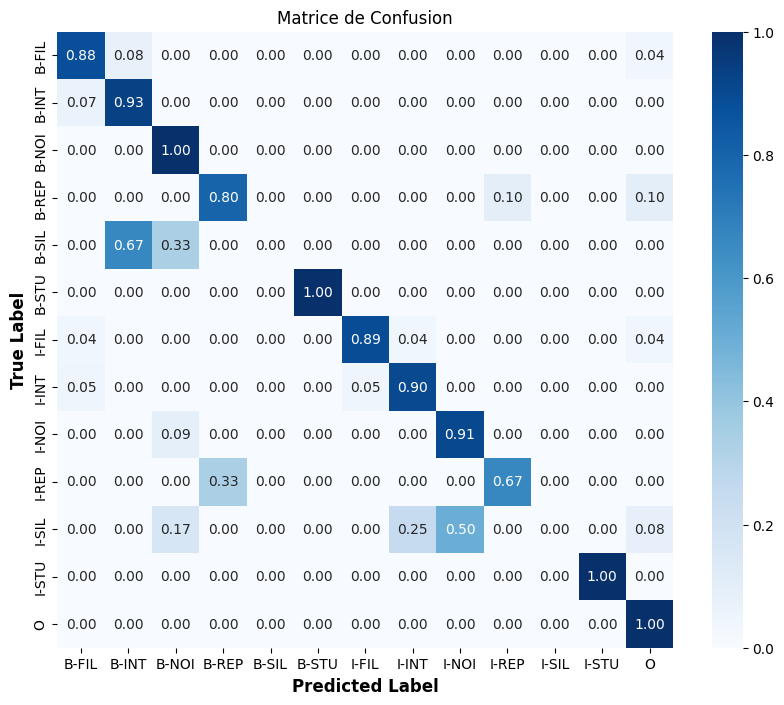


Rapport de Classification :
              precision    recall  f1-score   support

       B-FIL       0.88      0.88      0.88        26
       B-INT       0.78      0.93      0.85        15
       B-NOI       0.50      1.00      0.67         6
       B-REP       0.67      0.80      0.73        10
       B-SIL       0.00      0.00      0.00         3
       B-STU       1.00      1.00      1.00         3
       I-FIL       0.96      0.89      0.93        28
       I-INT       0.83      0.90      0.86        21
       I-NOI       0.83      0.91      0.87        33
       I-REP       0.67      0.67      0.67         3
       I-SIL       0.00      0.00      0.00        12
       I-STU       1.00      1.00      1.00        11
           O       1.00      1.00      1.00      1053

    accuracy                           0.97      1224
   macro avg       0.70      0.77      0.73      1224
weighted avg       0.96      0.97      0.97      1224



c:\Users\devme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\devme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\devme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [4]:
import os
import numpy as np
import tensorflow as tf
from transformers import logging as hf_logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
hf_logging.set_verbosity_error()

from transformers import BertTokenizerFast, TFBertForTokenClassification
from utils import encode_data, load_data, prepare_labels, evaluate_model, save_model, get_metrics

# access csv & load data
train_path = os.path.join(os.getcwd(), '..', 'data', 'train-data-derush.csv')
test_path = os.path.join(os.getcwd(), '..', 'data', 'test-data-derush.csv')
absolute_train_path = os.path.abspath(train_path)
absolute_test_path = os.path.abspath(test_path)

data_train, data_test = load_data(absolute_train_path, absolute_test_path) 

# encoding
unique_labels = ['O', 'B-STU', 'I-STU', 'B-FIL', 'I-FIL', 'B-REP', 'I-REP', 'B-INT', 'I-INT', 'B-NOI', 'I-NOI', 'B-SIL', 'I-SIL']
label_encoder = prepare_labels(unique_labels)

tokenizer = BertTokenizerFast.from_pretrained('google-bert/bert-base-multilingual-cased')

print("\n// Starting train data encoding...")
train_tokens, train_labels = encode_data(data_train, tokenizer, label_encoder, max_length=36)
print("\n// Starting test data encoding...")
test_tokens, test_labels = encode_data(data_test, tokenizer, label_encoder, max_length=36)

model = TFBertForTokenClassification.from_pretrained('google-bert/bert-base-multilingual-cased', num_labels=len(label_encoder.classes_))
print("-> model loaded with ", len(label_encoder.classes_), "labels")

# compile config
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# training
model.fit(train_tokens, train_labels, epochs=4, batch_size=9, validation_split=0.1)

# save
model_path = os.path.join(os.getcwd(), '..', 'models', 'bert-base-multilingual-cased')
absolute_model_path = os.path.abspath(model_path)
save_model(model, tokenizer, absolute_model_path)

# evaluate
evaluate_model(model, test_tokens, test_labels)

# Visualisation des métriques
test_pred = model.predict(test_tokens).logits
test_pred_labels = np.argmax(test_pred, axis=-1)

get_metrics(test_labels, test_pred_labels, label_encoder.classes_)
